In [3]:
#pip install tensorflow
# pip install tflearn
# pip  install tqdm (making it seem prettier than what it really is)
#NOTE
#Could not git commit files larger than 50MB, thus download the dataset from 
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition 

import cv2
import numpy as np #for arrays ofcourse
import os
import tensorflow
import tensorboard

from random import shuffle
from tqdm import tqdm

TRAIN_DIR = '/home/dev/Downloads/train'
TEST_DIR = '/home/dev/Downloads/test'
IMG_SIZE = 50 #this is is in essence the standard pic size
#IMG_SIZE = np.expand_dims(IMG_SIZ, axis=0)
LR = 1e-3

MODEL_NAME = 'dogsvscats--{}-{}.model'.format(LR, '6conv-basic-video')

In [4]:
def label_img(img):
    #dog.93.png splitting this in 3
    word_label = img.split('.')[-3]
    if word_label == 'cat': return[1,0]
    elif word_label == 'dog': return [0,1]

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
            path = os.path.join(TEST_DIR, img)
            img_num = img.split('.')[0]
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            testing_data.append([np.array(img), img_num])
                
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
train_data = create_train_data() 
#if you have trainied data
#train_data = np.load('train_data.npy')


100%|██████████| 25000/25000 [00:35<00:00, 706.33it/s]


In [8]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
#import tflearn.datasets.mnist as mnist

#X = X.reshape([-1, IMG_SIZE, IMG_SIZE, 1])
#test_x = test_x.reshape([-1, IMG_SIZE, IMG_SIZE, 1])

import tensorflow as tf
tf.reset_default_graph()


convnet = input_data(shape=[None, 50, 50, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')
    

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model has loaded!')

INFO:tensorflow:Restoring parameters from /home/dev/Desktop/Classifier/dogsvscats--0.001-6conv-basic-video.model
model has loaded!


In [10]:
train = train_data[:-500] 
#the data except the last 500
test = train_data[-500:]

In [11]:
#X = tf.placeholder(tf.float32 , [None ,28 , 28 , 1])
#X = tf.reshape(X , [-1 , 784])
#X = np.expand_dims(IMG_SIZ, axis=0)

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]


#test_x = np.expand_dims(IMG_SIZ, axis=0)
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#test_x = np.reshape(test_x, (-1, 28, 28, 1))
test_y = [i[1] for i in test]


In [12]:
#X = np.expand_dims(IMG_SIZE, axis=0)

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 3707  | total loss: 11.56675 | time: 118.448s
| Adam | epoch: 003 | loss: 11.56675 - acc: 0.4977 -- iter: 24448/24500
Training Step: 3708  | total loss: 11.56137 | time: 119.748s
| Adam | epoch: 003 | loss: 11.56137 - acc: 0.4979 | val_loss: 11.83529 - val_acc: 0.4860 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/dev/Desktop/Classifier/dogsvscats--0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:28<00:00, 444.24it/s]


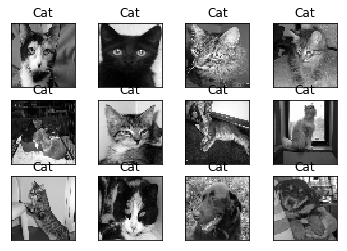

In [14]:
import matplotlib.pyplot as plt

#if you dont have the file yet
test_data = process_test_data()
#if you already have it
#test_dat = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    